In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tdc.multi_pred import DTI

data = DTI(name = 'DAVIS')
data.convert_to_log(form = 'binding')
df = data.get_data()

print(f"Shape of the dataset: {df.shape}")
print(df.head())

Downloading...
100%|██████████| 21.4M/21.4M [00:05<00:00, 3.98MiB/s]
Loading...
Done!
To log space...


Shape of the dataset: (25772, 5)
    Drug_ID                                           Drug Target_ID  \
0  11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      AAK1   
1  11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ABL1p   
2  11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      ABL2   
3  11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ACVR1   
4  11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12    ACVR1B   

                                              Target         Y  
0  MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...  7.365523  
1  PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...  4.999996  
2  MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...  4.999996  
3  MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...  4.999996  
4  MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...  4.999996  


Simple Random Split (80% Train, 10% Validation, 10% Test)
- May have data leakage (same drugs & proteins in train/test)

In [3]:
from sklearn.model_selection import train_test_split
# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print dataset sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Save the datasets
train_df.to_csv('randomSplit/davis_train.csv', index=False)
valid_df.to_csv('randomSplit/davis_valid.csv', index=False)
test_df.to_csv('randomSplit/davis_test.csv', index=False)

Train size: 20617
Validation size: 2577
Test size: 2578


Cold Drug Split (Test Drugs Never Seen in Training) (also could be like pharos bc we want to see if the understudied will be selected for an unseen drug?)
- Might leave few test proteins, leading to imbalance
- Ensures generalization to unseen drugs
Since DAVIS is fully connected, all proteins appear in both train and test sets (just paired with different drugs).

In [ ]:
import numpy as np

# Get unique drugs
unique_drugs = df['Drug'].unique()

# Split drugs into 80% train, 10% valid, 10% test
train_drugs, temp_drugs = train_test_split(unique_drugs, test_size=0.2, random_state=42)
valid_drugs, test_drugs = train_test_split(temp_drugs, test_size=0.5, random_state=42)

# Assign data based on drug presence
train_df = df[df['Drug'].isin(train_drugs)]
valid_df = df[df['Drug'].isin(valid_drugs)]
test_df = df[df['Drug'].isin(test_drugs)]

# Print dataset sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Save datasets
train_df.to_csv('coldDrugSplit/davis_train_cold_drug.csv', index=False)
valid_df.to_csv('coldDrugSplit/davis_valid_cold_drug.csv', index=False)
test_df.to_csv('coldDrugSplit/davis_test_cold_drug.csv', index=False)


Cold Protein Split (Test Proteins Never Seen in Training) (MORE LIKE PHAROS bc we can see how accurate predictions of interactions are for proteins that were previously uncharacterized.)
- Ensures generalization to new proteins
- May overload test set with certain drugs
Since every drug interacts with every protein, removing some proteins from training also removes their drug interactions.
This means that the test set will only have drugs that were seen in training but paired with unseen proteins.
Problem: Some drugs might become underrepresented in training, which could make the test set unrealistic? but not here by fully connected?

Can be really specific with splitting i guess

In [ ]:
unique_proteins = df['Target'].unique()
print(unique_proteins.size)

# Split proteins into 80% train, 10% valid, 10% test
train_prots, temp_prots = train_test_split(unique_proteins, test_size=0.2, random_state=42)
valid_prots, test_prots = train_test_split(temp_prots, test_size=0.5, random_state=42)
print(train_prots.size)
print(test_prots.size)
print(valid_prots.size)
# Assign data based on protein presence
train_df = df[df['Target'].isin(train_prots)]
valid_df = df[df['Target'].isin(valid_prots)]
test_df = df[df['Target'].isin(test_prots)]

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Save
train_df.to_csv('coldProteinSplit/davis_train_cold_protein.csv', index=False)
valid_df.to_csv('coldProteinSplit/davis_valid_cold_protein.csv', index=False)
test_df.to_csv('coldProteinSplit/davis_test_cold_protein.csv', index=False)
# Save protein lists to text files
with open("coldProteinSplit/train_proteins.txt", "w") as f:
    f.write("\n".join(train_prots))

with open("coldProteinSplit/valid_proteins.txt", "w") as f:
    f.write("\n".join(valid_prots))

with open("coldProteinSplit/test_proteins.txt", "w") as f:
    f.write("\n".join(test_prots))

print("Protein lists saved!")

train_set = set(train_prots)
valid_set = set(valid_prots)
test_set = set(test_prots)

# Check for overlap
overlap_train_valid = train_set & valid_set
overlap_train_test = train_set & test_set
overlap_valid_test = valid_set & test_set

print("Overlap between Train & Validation:", overlap_train_valid)
print("Overlap between Train & Test:", overlap_train_test)
print("Overlap between Validation & Test:", overlap_valid_test)

379
303
38
38
Train size: 20604
Validation size: 2584
Test size: 2584
Protein lists saved!
Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()


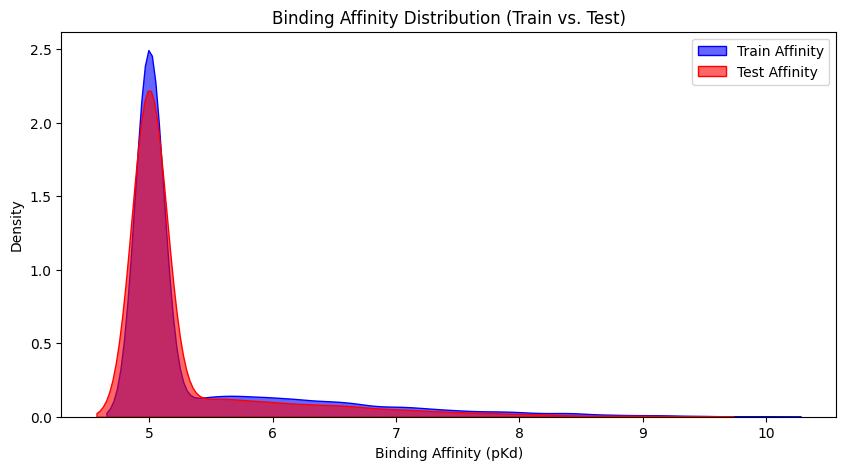

No protein overlap between training and test sets!


In [18]:
plt.figure(figsize=(10, 5))
sns.kdeplot(train_df["Y"], fill=True, label="Train Affinity", color="blue", alpha=0.6)
sns.kdeplot(test_df["Y"], fill=True, label="Test Affinity", color="red", alpha=0.6)

plt.xlabel("Binding Affinity (pKd)")
plt.ylabel("Density")
plt.title("Binding Affinity Distribution (Train vs. Test)")
plt.legend()
plt.show()

# Ensure no overlap in proteins
assert len(set(train_df["Target"]) & set(test_df["Target"])) == 0, "Leakage detected!"
print("No protein overlap between training and test sets!")


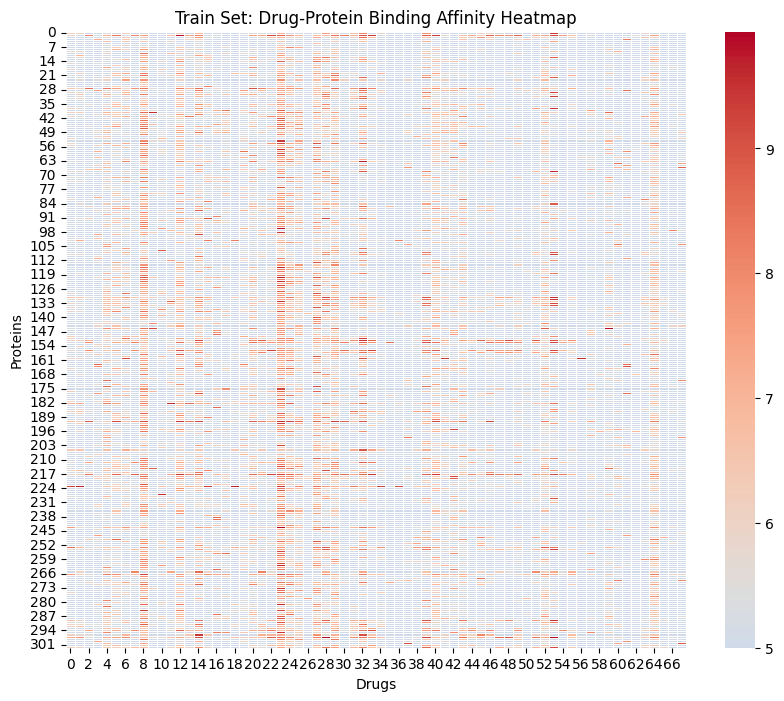

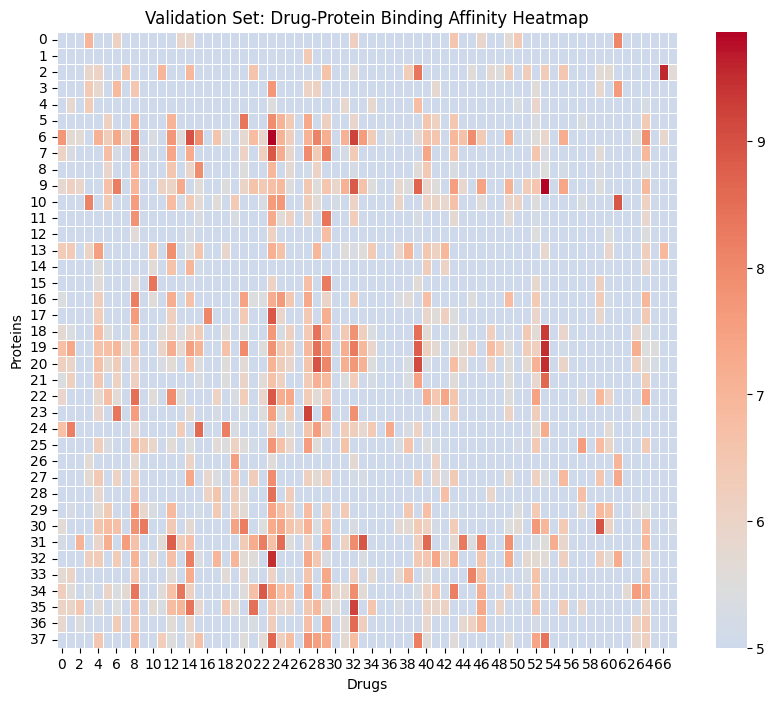

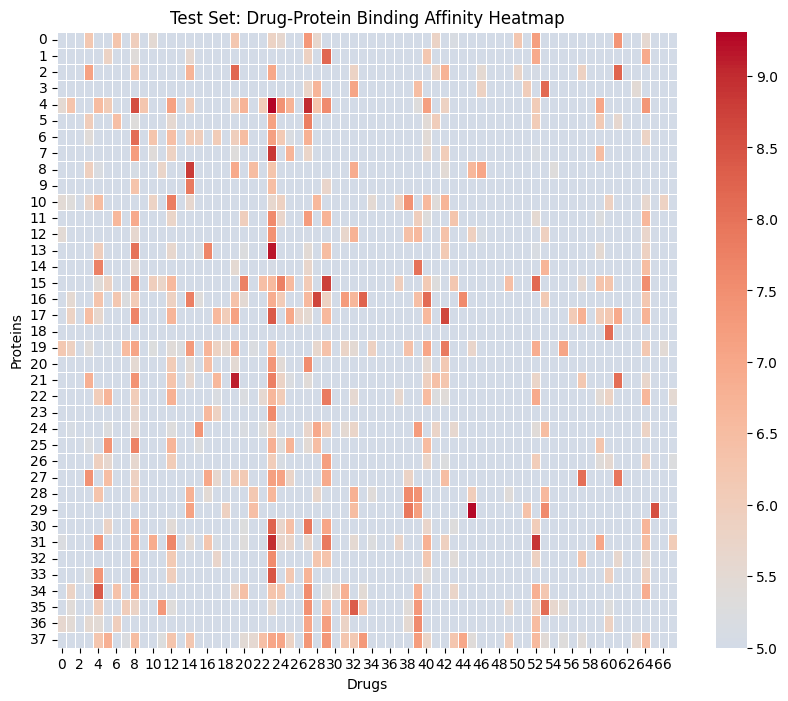

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title):
    """Plots a heatmap of drug-protein binding affinities."""
    # Pivot to create a drug-protein matrix
    interaction_matrix = df.pivot(index="Target", columns="Drug", values="Y")
    
    # Handle missing values (if any) by replacing NaNs with the mean affinity
    interaction_matrix.fillna(df["Y"].mean(), inplace=True)
    interaction_matrix.index = range(len(interaction_matrix.index))  # Replace proteins with numbers
    interaction_matrix.columns = range(len(interaction_matrix.columns))  # Replace drugs with numbers

    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(interaction_matrix, cmap="coolwarm", center=np.nanmean(df["Y"]), linewidths=0.5)
    
    plt.xlabel("Drugs")
    plt.ylabel("Proteins")
    plt.title(title)
    plt.show()

# Generate heatmaps for each set
plot_heatmap(train_df, "Train Set: Drug-Protein Binding Affinity Heatmap")
plot_heatmap(valid_df, "Validation Set: Drug-Protein Binding Affinity Heatmap")
plot_heatmap(test_df, "Test Set: Drug-Protein Binding Affinity Heatmap")
